In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train_clean.csv", index_col=0)

In [5]:
def transform_dataset(df, testsize):
    df = df.drop(columns=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                          'LotConfig', 'Condition1', 'Condition2','BldgType', 'HouseStyle', 'RoofStyle',
                          'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1',
                          'BsmtFinType2', 'BsmtFinSF2', 'Heating','Electrical', 'GarageType', 'GarageYrBlt', 
                          'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', "MasVnrArea"])

    df["LotFrontage"] = df.groupby('Neighborhood')["LotFrontage"].transform(lambda a: a.fillna(a.median()))
    df["LandSlope"] = df["LandSlope"].apply(lambda x: 0 if x=="Gtl" else( 1 if x=="Mod" else 2))
    df["ExterQual"] = df["ExterQual"].apply(lambda x: 0 if x=="Po" else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    df["ExterCond"] = df["ExterCond"].apply(lambda x: 0 if x=="Po" else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    for feature in ("BsmtExposure", "BsmtQual", "BsmtCond"):
        df[feature] = df[feature].fillna('NoBsmt')
    df["BsmtQual"] = df["BsmtQual"].apply(lambda x: 0 if x in ("NoBsmt", "Po") else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    df["BsmtCond"] = df["BsmtCond"].apply(lambda x: 0 if x in ("NoBsmt", "Po") else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    df["BsmtExposure"] = df["BsmtExposure"].apply(lambda x: 0 if x =="NoBsmt" else( 1 if x=="No" else (2 if x=="Mn" else (3 if x=="Av" else 4))))
    df["HeatingQC"] = df["HeatingQC"].apply(lambda x: 0 if x=="Po" else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    df["CentralAir"] = df["CentralAir"].apply(lambda x: 0 if x=="No" else 1)
    df["KitchenQual"] = df["KitchenQual"].apply(lambda x: 0 if x=="Po" else( 1 if x=="Fa" else (2 if x=="TA" else (3 if x=="Gd" else 4))))
    df["Functional"] = df["Functional"].apply(lambda x: 0 if x=="Sal" else( 1 if x=="Sev" else (2 if x=="Maj2" else 
                                             (3 if x=="Maj1" else (4 if x=="Mod" else(5 if x=="Min2" else(6 if x=="Min1" else 7)))))))
    df["FireplaceQu"] = df["FireplaceQu"].fillna('No')
    df["FireplaceQu"] = df["FireplaceQu"].apply(lambda x: 0 if x=="No" else( 1 if x=="Po" else (2 if x=="Fa" else (3 if x=="TA" else (4 if x=="Gd" else 5)))))
    df["GarageFinish"] = df["GarageFinish"].fillna('No')
    df["GarageFinish"] = df["GarageFinish"].apply(lambda x: 0 if x=="No" else( 1 if x=="Unf" else (2 if x=="RFn" else 3)))
    df["PavedDrive"] = df["PavedDrive"].apply(lambda x: 0 if x=="N" else( 1 if x=="P" else 2))
    df["DateSold"] = df["YrSold"] + df["MoSold"].apply(lambda x: (x-1)/12)
    df = df.drop(columns=["YrSold", "MoSold"])
       
    X = df.drop(columns=["SalePrice"]) 
    y = df["SalePrice"]
    train, test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    
    ohe = OneHotEncoder(handle_unknown="ignore")
    for feature in ["Neighborhood", "SaleType", "SaleCondition"]:
        ohe.fit(train[feature].values.reshape(-1, 1))
        train_encoded = pd.DataFrame(ohe.transform(train[feature].values.reshape(-1, 1)).toarray(), 
                               index=train.index, columns=[feature + i for i in ohe.categories_[0]])
        train = train.merge(train_encoded, right_index=True, left_index=True).drop(columns=feature)
        test_encoded = pd.DataFrame(ohe.transform(test[feature].values.reshape(-1, 1)).toarray(), 
                               index=test.index, columns=[feature + i for i in ohe.categories_[0]])
        test = test.merge(test_encoded, right_index=True, left_index=True).drop(columns=feature)
        
    scaler = StandardScaler()
    for feature in train.columns[:44]:
        scaler.fit(train[feature].values.reshape(-1, 1))
        train[feature] = scaler.transform(train[feature].values.reshape(-1, 1))
        test[feature] = scaler.transform(test[feature].values.reshape(-1, 1))
        
    scaler.fit(y_train.values.reshape(-1, 1))
    params = [scaler.mean_[0], np.sqrt(scaler.var_[0])]
    y_train = scaler.transform(y_train.values.reshape(-1, 1))
    y_test = scaler.transform(y_test.values.reshape(-1, 1))
    
    return train, test, y_train, y_test, params

In [6]:
X_train, X_test, y_train, y_test, params = transform_dataset(df, 0.2)

In [7]:
pd.Series(params, index=["mean", "std"]).to_csv("y_reverse_transformation.csv")

In [8]:
variance = []
for d in range(1, 45):
    pca = PCA(n_components=d)
    pca.fit(X_train.iloc[:,:44])
    variance.append(pca.explained_variance_ratio_.sum())

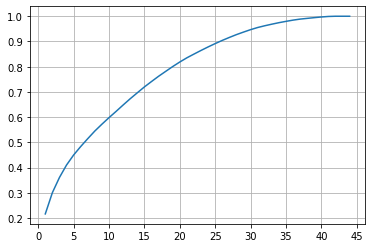

In [9]:
plt.plot(range(1, 45), variance)
#plt.yticks(np.arange(0,11)/10)
plt.xticks(np.arange(0,50,5))
plt.grid()
plt.savefig("visualizations/PCA.png", dpi=600, bbox_inches="tight")

In [10]:
def pct_dataset(train, test, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(train.iloc[:,:44])
    train_num = pd.DataFrame(pca.transform(train.iloc[:,:44]), index=train.index)
    test_num = pd.DataFrame(pca.transform(test.iloc[:,:44]), index=test.index)
    
    scaler = StandardScaler()
    for feature in train_num.columns:
        scaler.fit(train_num[feature].values.reshape(-1, 1))
        train_num[feature] = scaler.transform(train_num[feature].values.reshape(-1, 1))
        test_num[feature] = scaler.transform(test_num[feature].values.reshape(-1, 1))
        
    train = train.drop(columns=train.columns[:44]).join(train_num)
    test = test.drop(columns=test.columns[:44]).join(test_num)
    return train, test

In [11]:
X_train, X_test = pct_dataset(X_train, X_test, 25)

In [12]:
X_train.to_csv("X_train.csv")
pd.DataFrame(y_train, columns=["SalePrice"]).to_csv("y_train.csv")
X_test.to_csv("X_test.csv")
pd.DataFrame(y_test, columns=["SalePrice"]).to_csv("y_test.csv")